In [17]:
from plotnine.data import *
from plotnine import *
from matplotlib import ticker
import sys
sys.path.append('.')
sys.path.append('..')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import numpy as np
import os
import mne
from scipy.io import loadmat
import pandas as pd
import seaborn.objects as so
from tqdm import tqdm
from matplotlib.pyplot import MultipleLocator
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

### default parapmeters

In [18]:
plt.rcParams['font.size'] = '5'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

cm = 1/2.54
# 每次调用font dict
fontdict = dict(fontsize=7, family='Arial')

# Fig1

In [3]:
Add = '../stimulation/sweep/STI.mat'
broad = loadmat(Add)['wn'][0]

t = np.linspace(0,1,60)
narrow = np.sin(2*np.pi*8*t)

t = np.linspace(0,1,240)
broad = np.repeat(broad,4)
narrow = np.repeat(narrow, 4)

In [ ]:
sns.set_theme(style='ticks',)
f, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(t, broad, color='black', linewidth=0.5)
ax2.plot(t, narrow,color='black',linewidth=0.5)

ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Luminosity')
ax1.set_ylabel('Luminosity')

ax1.tick_params(width=0.4, length=4, which='major')
ax2.tick_params(width=0.4, length=4, which='major')

sns.despine()
plt.setp(ax1.spines.values(), linewidth=0.4)
plt.setp(ax2.spines.values(), linewidth=0.4)

plt.savefig('../images/sti.svg',dpi=300,format='svg')

In [ ]:
f = np.linspace(0,50,200)

broad = np.repeat(1,200)
narrow = np.repeat(0,200)
narrow[(np.argmin(np.abs(f-8)))]=2

In [ ]:
sns.set_theme(style='ticks',)
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(3,5))

ax1.plot(f, broad, color='black', linewidth=0.5)
ax2.plot(f, narrow, color='black', linewidth=0.5)

ax2.set_xlabel('Frequency(Hz)')
ax2.set_ylabel('PSD')
ax1.set_ylabel('PSD')

ax1.tick_params(width=0.4, length=4, which='major')
ax2.tick_params(width=0.4, length=4, which='major')

ax1.set_ylim(0,2)
sns.despine()
plt.setp(ax1.spines.values(), linewidth=0.4)
plt.setp(ax2.spines.values(), linewidth=0.4)

plt.savefig('../images/sti-spec.svg', dpi=300, format='svg')

# Fig 2

In [ ]:
srate = 250
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)


STIadd = '../stimulation/%s/STI.mat' % expName
STI = loadmat(STIadd)['wn']

sub = wholeset[4]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']


In [ ]:
srate = 250
winLEN = 3
classNUM = 160
tmin, tmax = 0, .8
n_band = 3
# penalty
p = 0.95

In [ ]:
# reshape to class*block*chn*N
X_ = np.stack(X[y == i] for i in np.unique(y))
y_ = np.stack(y[y == i] for i in np.unique(y))

# split conditions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_,test_size=0.2,train_size=0.8,random_state=253)

X_train,X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)
y_train,y_test = np.concatenate(y_train, axis=0), np.concatenate(y_test, axis=0)
S_train,S_test = np.stack([S[i-1] for i in y_train]),np.stack([S[i-1] for i in y_test])

In [ ]:
from modeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True,n_band=n_band,component=1)
code2EEG.fit(X_train,y_train)

R_ = code2EEG.predict(S_test)
R = code2EEG.enhancer.transform(X_test)

In [ ]:
inx = 1
R_ave = np.stack([R[y_test == i] for i in np.unique(y_test)]).mean(axis=1)
R_ave_ = np.stack([R_[y_test == i] for i in np.unique(y_test)]).mean(axis=1)
rhos = np.zeros((n_band, R_ave.shape[0], R_ave_.shape[0]))
for i, r in enumerate(R_ave):
    for j, r_ in enumerate(R_ave_):
        for fbINX, (fb_r, fb_r_) in enumerate(zip(r, r_)):
            rho = np.corrcoef(fb_r, fb_r_)[0, 1]
            rhos[fbINX, i, j] = rho

In [ ]:
fig = plt.figure(figsize=(8.8*cm, 10*cm))

plt.subplots_adjust(wspace=1,hspace=1)
ax1 = plt.subplot2grid((7, 6), (1, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((7, 6), (0, 2), colspan=5, rowspan=2)
ax3 = plt.subplot2grid((7, 6), (3, 2), colspan=5, rowspan=2)

ax0 = plt.subplot2grid((7, 6), (2, 2), colspan=5,rowspan=1,)


ax4 = plt.subplot2grid((7, 6), (5, 0), colspan=2, rowspan=2)
ax5 = plt.subplot2grid((7, 6), (5, 2), colspan=2, rowspan=2)
ax6 = plt.subplot2grid((7, 6), (5, 4), colspan=2, rowspan=2)

for ax in fig.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

# TRF
tau = np.arange(tmin, tmax, step=1/srate)
ax1.plot(tau[:100], code2EEG.trf[0, :100], color='black',linewidth=1)
ax1.set_ylim(-0.1,0.2)

# stimulus
s = np.repeat(STI[np.unique(y_) == y_test[inx]], 4)
t = np.linspace(0, 1, len(s))
ax2.plot(t, s,linewidth=1)


for spine in ['top', 'right','bottom']:
    ax2.spines[spine].set_visible(False)
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

# ax2.spines['bottom'].set_position(('data', 0.5))

t = np.linspace(0, 1, len(R[inx][0].T))
ax3.plot(t,R[inx][0].T,linewidth=1)
ax3.plot(t, R_[inx][0].T, linewidth=1)

# ax3.spines['bottom'].set_position(('data', 0))
for spine in ['top', 'right', 'bottom']:
    ax3.spines[spine].set_visible(False)
ax3.set_xticklabels([])
ax3.set_xticks([])

for spine in ['top', 'right', 'left']:
    ax0.spines[spine].set_visible(False)
ax0.spines['bottom'].set_position(('data', 1))
ax0.set_yticklabels([])
ax0.set_yticks([])

ax0.set_xlabel('Time(s)',fontdict=fontdict)
ax0.tick_params(direction='inout')

ax4.pcolormesh(rhos[0], cmap='vlag')
ax5.pcolormesh(rhos[1], cmap='vlag')
ax6.pcolormesh(rhos[2], cmap='vlag')


sns.despine(ax=ax1,offset=5,)
plt.savefig('../images/modeling.svg',dpi=400)

# Fig3

### Fig 3(a) : distribution

In [14]:
sweep = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'classification.csv'):
        f = pd.read_csv(subFolder+os.sep+'classification.csv')
        sweep.append(f)

sweep = pd.concat(sweep, ignore_index=True).drop_duplicates()
sweepAve = sweep.groupby(['subject','seed','winLEN'],as_index=False).mean()
sweepWhole = sweep[sweep.seed==1].groupby(['winLEN','subject'],as_index=False).mean()
sweep.head()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_25124/247474423.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_25124/247474423.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,Unnamed: 0,accuracy,winLEN,ITR,method,cv,seed,subject,score
0,0,0.600,0.1,223.681661,wn,0,0,yangyuxing,0.5375
1,1,0.750,0.1,318.929942,wn,0,1,yangyuxing,0.5375
2,2,0.675,0.1,269.443625,wn,0,2,yangyuxing,0.5375
3,3,0.675,0.1,269.443625,wn,0,3,yangyuxing,0.5375
4,4,0.625,0.1,238.546826,wn,0,4,yangyuxing,0.5375


In [15]:
groupOpt = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'groupOpt.csv'):
        f = pd.read_csv(subFolder+os.sep+'groupOpt.csv')
        groupOpt.append(f)

groupOpt = pd.concat(groupOpt, ignore_index=True).drop_duplicates()
groupOpt = groupOpt.groupby(['seed','method','subject'],as_index=False).mean()
groupOpt.head()

,seed,method,subject,Unnamed: 0,accuracy,winLEN,cv
0,0,random,chenyuzhen,7500.0,0.929167,0.3,2.5
1,0,random,fanzixiao,17500.0,0.962500,0.3,2.5
2,0,random,huangzixun,22500.0,0.954167,0.3,2.5
3,0,random,miaoyining,27500.0,0.979167,0.3,2.5
4,0,random,shinanlin,32500.0,0.875000,0.3,2.5


In [ ]:
f,(ax1) = plt.subplots(1,1,figsize=(6*cm,5.5*cm))

for ax in f.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)
    
sns.set_theme(style='ticks')

sns.boxplot(data=sweepWhole, x='winLEN', y='score',
            ax=ax1, flierprops={"marker": "x"}, whis=4,palette='vlag',linewidth=0.5,fliersize=0.5)

sns.swarmplot(data=sweepWhole, x='winLEN', y='score',
            hue='subject', ax=ax1,palette='vlag',size=3)

ax1.legend([])

ax1.set_xlabel('Time(s)',fontdict=fontdict)
ax1.set_ylabel('Accuracy',fontdict=fontdict)

f.savefig('../images/fig3a1.svg',dpi=300)

In [ ]:
df = sweepAve[sweepAve.winLEN==0.3][['subject','accuracy']]
df['subINX'] = 0

for i, subName in enumerate(df.subject.unique()):
    df.loc[df.subject == subName, 'subINX'] = 'S%s' % (i+1)

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="subINX", hue="subINX", aspect=10, height=.6*cm, palette='crest')

# Draw the densities in a few steps
g.map(sns.kdeplot, "accuracy",
      bw_adjust=3, clip_on=False,
      fill=True, alpha=1, linewidth=0.1,cut=1)
g.map(sns.kdeplot, "accuracy", clip_on=False, color="w", lw=0.5, bw_adjust=3)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=0.1, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.set_xlim(0.76,1.01)
    ax.text(0, .2, label, color=color,
            ha="left", va="center", transform=ax.transAxes,fontdict=fontdict)
g.map(label, "accuracy")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.7)

for ax in g.axes.flatten():
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.set_xlabels('Accuracy',fontdict=fontdict)
g.despine(bottom=False, left=True)
g.savefig('../images/fig3a2.svg', dpi=300)

### Fig 3(b) : optimization efficiency

In [ ]:
ave = groupOpt[(groupOpt.winLEN==0.3)&(groupOpt.subject!='chenziyu')].groupby(['method'],as_index=False).mean()

sns.set_theme(style='ticks')

f,ax=plt.subplots(figsize=(8.5*cm,5.6*cm))

axins = ax.inset_axes((0.2, 0.5, 0.4, 0.4))

hist = sns.histplot(data=groupOpt,
             x='accuracy',hue='method',element='step',bins=50,legend=False)

for (method, color) in zip(['random', 'simulate', 'real'], ['#2A2B2DFF', '#00239CFF', '#E10600FF']):
    value = ave[ave.method == method].accuracy.mean()
    hist.axvline(x=value, linestyle='dashed', color=color, linewidth=1,)

sns.lineplot(data=groupOpt, x='method', y='accuracy',
             ax=axins, err_style="bars", errorbar='ci',markers=True,hue='method',legend=False,)

sns.lineplot(data=groupOpt, x='method', y='accuracy',
             ax=axins, err_style="bars", errorbar='ci',linewidth=0.5,color='black')

ax.set_xlim(0.82, 1)
ax.set_xlabel('Accuracy',fontdict=fontdict)
ax.set_ylabel('Count',fontdict=fontdict)

axins.set_xlabel('Method',fontdict=fontdict)
axins.set_ylabel('Accuracy',fontdict=fontdict)
axins.set_ylim(0.945,0.97)


for ax in [ax,axins]:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

f.savefig('../images/fig3b.svg', dpi=300)

In [ ]:
from scipy import stats

c = [['real','random'],['real','simulate'],['simulate','random']]
pairwise=[]
for i,(m1,m2) in enumerate(c):

        print(m1,m2)

        test = stats.ttest_rel(groupOpt.loc[groupOpt.method == m1].accuracy.to_numpy(),
                               groupOpt.loc[groupOpt.method == m2].accuracy.to_numpy())
        pairwise.append({
            'methods':'%s-%s'%(m1,m2),
            'pval':test.pvalue,
        })
pairwise

### Fig 3(c) : codeset comparsion

In [ ]:
distance = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'distance.csv'):
        f = pd.read_csv(subFolder+os.sep+'distance.csv')
        distance.append(f)
    
distance = pd.concat(distance, ignore_index=True)

d1 = distance[distance.codeset=='C1'].pivot_table(index='i',columns='j',values='distance')
d2 = distance[distance.codeset == 'C2'].pivot_table(
    index='i', columns='j', values='distance')

distance.head()

In [ ]:
sns.set_theme(style='ticks')
fig = plt.figure(figsize=(6.5*cm, 5.6*cm))

plt.subplots_adjust(wspace=0.4,hspace=0.5)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)

hist = sns.histplot(data=distance, x='distance', hue='codeset', ax=ax1, legend=False, palette=[
                    '#21468B', '#AE1C28'], bins=80, kde=False, line_kws={'linewidth': 0.5})

ax1.set_ylabel('Count',fontdict=fontdict)
ax1.set_xlabel('Codeset Distance',fontdict=fontdict)

a = ax2.imshow(d1, cmap='vlag', vmin=50, vmax=500, interpolation='none')
ax3.imshow(d2, cmap='vlag', vmin=50, vmax=500,)

cax = plt.axes([0.3, 0.1, 0.02, 0.31])

ax2.xaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))
ax2.yaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))
ax3.xaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))
ax3.yaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))

ax2.set_xlabel('class',fontdict=fontdict)
ax3.set_xlabel('class',fontdict=fontdict)
ax2.set_ylabel('class', fontdict=fontdict)


for ax in fig.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

plt.colorbar(a, cax=cax,)
plt.savefig('../images/fig3c.svg',dpi=300)

In [ ]:
f,ax = plt.subplots()
ax.imshow(d2.to_numpy()[:25][:, :25], cmap='vlag', interpolation='none')
ax.set_axis_off()
plt.savefig('../images/fig3c1.svg',dpi=300)

### Fig 3(d) : topography of 160 and 40 class

In [ ]:
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = 2
chNames = wholeset[sub]['channel']
X = wholeset[sub]['wn']['X']
y = wholeset[sub]['wn']['y']

chnINX = [chNames.index(i) for i in chNames if i not in [
    'M1', 'M2', 'CB1', 'CB2']]

X = X[:, chnINX]
for i in ['M1', 'M2', 'CB1', 'CB2']:
    chNames.remove(i)

wholeset[sub]['name']

In [ ]:
info = mne.create_info(ch_names=chNames, sfreq=250, ch_types='eeg')
fname = 'montage.loc'
montage = mne.channels.read_custom_montage(fname)
info.set_montage(montage)

In [ ]:
from mne.viz import plot_topomap
from spatialFilters import TDCA
import random

bigModel = TDCA(srate=250, montage=160, lag=0.14, winLEN=0.3)
bigModel.fit(X, y)
bigPattern = np.squeeze(bigModel.pattern)

random.seed(2)
targetNUM = 40
picked = random.sample(list(np.unique(y)), targetNUM)
X_picked = np.concatenate([X[y == i] for i in picked])
y_picked = np.concatenate([y[y == i] for i in picked])

lilModel = TDCA(srate=250, montage=160, lag=0.14, winLEN=0.3)
lilModel.fit(X_picked, y_picked)
lilPattern = np.squeeze(lilModel.pattern)

In [ ]:
from sklearn.model_selection import LeaveOneOut

X = np.stack([X[y == i] for i in np.unique(y)])
y = np.stack([y[y == i] for i in np.unique(y)])

# classification
X = np.transpose(X, axes=(1, 0, -2, -1))
y = np.transpose(y, axes=(-1, 0))

loo = LeaveOneOut()
loo.get_n_splits(X)

matrices = []
for cv, (train_index, test_index) in enumerate(loo.split(X, y)):

    X_train, X_test = np.concatenate(
        X[train_index]), np.concatenate(X[test_index])
    y_train, y_test = np.concatenate(
        y[train_index]), np.concatenate(y[test_index])

    model = TDCA(winLEN=0.3,lag=0.14,srate=250,montage=160,n_band=1)
    model.fit(X_train,y_train)
    score = model.score(X_test,y_test)
    coefMatrix = model.rho

    matrices.append(coefMatrix)

matrices = np.stack(matrices)

In [ ]:
m = sns.color_palette("vlag", as_cmap=True)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(3.3*cm,5.6*cm))

plot_topomap(data=bigPattern, pos=info, cmap=m, contours=0,
                   image_interp='bicubic', axes=ax1, show=False)
plot_topomap(data=lilPattern, pos=info, cmap=m, contours=0,
                   image_interp='bicubic', axes=ax2, show=False)

ax1.set_title('160 classes',fontdict=fontdict)
ax2.set_title('40 classes',fontdict=fontdict)

fig.savefig('../images/fig3e.svg',dpi=300)


In [ ]:
fig, axes = plt.subplots(1, 6,figsize=(10,1.5))
for i in range(6):
    axes[i].imshow(matrices[i],cmap='vlag',vmin=-0.5,vmax=0.8)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

fig.savefig('../images/fig3f.svg', dpi=300)

### Fig3(e) group response

In [ ]:
fAdd = '../seqOpt/mat/preliminary.mat'
data = loadmat(fAdd)['S11']
real = data[0]['pattern'][0][0].T
simulate = data[0]['simulate'][0][0].T

sti = np.repeat(np.random.random((10, 60)),4,axis=-1)

In [ ]:
f,axes = plt.subplots(6,3)
plt.subplots_adjust(hspace=-0.3)


for i,ax in enumerate(axes):

    ax[0].plot(real[i+10,], linewidth=1,color='#21468B')
    ax[1].plot(simulate[i+10], linewidth=1, color='#AE1C28')
    ax[2].plot(sti[i],linewidth=1,color='black')

    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')

    ax[0].set_ylim(-5,5)
    ax[1].set_ylim(-5, 5)
    ax[2].set_ylim(-1.5, 1.5)
    

f.savefig('../images/fig3e.svg',dpi=300)

# Fig 4

### Fig 4(a) Accuracy with time

In [19]:
compare = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'classification.csv'):
        f = pd.read_csv(subFolder+os.sep+'classification.csv')
        compare.append(f)
    
compare = pd.concat(compare, ignore_index=True)
compare = compare.groupby(['subject','winLEN','method'],as_index=False).mean()
compare.head()

,subject,winLEN,method,Unnamed: 0,accuracy,ITR,cv,seed,score
0,alicia,0.1,SSVEP,57.5,0.20000,37.593233,3.5,0.0,NaN
1,alicia,0.1,WN,17.5,0.23750,51.224983,3.5,0.0,NaN
2,alicia,0.2,SSVEP,58.5,0.28125,57.751851,3.5,0.0,NaN
3,alicia,0.2,WN,18.5,0.39375,99.827846,3.5,0.0,NaN
4,alicia,0.3,SSVEP,59.5,0.38125,83.572403,3.5,0.0,NaN


In [20]:
compare.subject.unique()

array(['alicia', 'chenyuzhen', 'ehab', 'fanzixiao', 'gongcongcong',
       'hanyue', 'jiaqi', 'jingyi', 'liangfangshuo', 'libowen',
       'lijiayang', 'miaoyining', 'quyuxin', 'rafi', 'shixinge',
       'sunjinnan', 'suxiaohan', 'wangchaoying', 'weiyichen', 'xuwenjia',
       'yangyuxing', 'yaofeifan', 'yuciheng', 'zhaoxinyu', 'zhengjiahan',
       'zhouyuqing'], dtype=object)

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_24512/3476377864.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


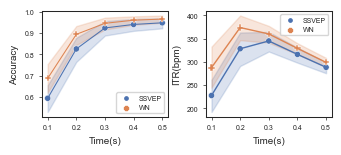

In [21]:
sns.set_theme(style='ticks')
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9.5*cm,3.5*cm))

plt.subplots_adjust(wspace=0.3)

list = ['yangyuxing', 'jingyi','xuwenjia',
        'fanzixiao', 'wangchaoying', 'lijiayang', 
        'libowen', 'zhouyuqing', 'miaoyining', 
        'yaofeifan','chenyuzhen','shixinge',
        'suxiaohan','quyuxin','zhaoxinyu',
        'jiaqi', 'hanyue', 'weiyichen','liangfangshuo']

f = compare[compare.subject.isin(list)]
fAve = f.groupby(['winLEN','method'],as_index=False).mean()


sns.lineplot(data=f, x='winLEN', y='accuracy', hue='method', ax=ax1, linewidth=0.75,
             err_style='band', dashes=True, legend=False, markers=True,)

sns.scatterplot(data=fAve, x='winLEN', y='accuracy',
                hue='method', ax=ax1, style='method', s=20, markers=['o', 'P'])


sns.lineplot(data=f, x='winLEN', y='ITR', hue='method', ax=ax2, linewidth=1,
             err_style='band', dashes=True, legend=False,)

sns.scatterplot(data=fAve, x='winLEN', y='ITR',
                hue='method', ax=ax2, style='method',s=20,markers=['o', 'P'])


ax1.set_ylabel('Accuracy',fontdict=fontdict)
ax2.set_ylabel('ITR(bpm)', fontdict=fontdict)

for ax in fig.axes:

    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xlabel('Time(s)',fontdict=fontdict)
    ax.legend(fontsize=5, markerscale=0.4)
    
plt.show()

fig.savefig('../images/fig4a.png', dpi=400, bbox_inches='tight')
fig.savefig('../images/fig4a.svg', dpi=400, bbox_inches='tight')

In [6]:
highITR = []

for subject in list:
    for method in compare.method.unique():
            f = compare[(compare.subject == subject) & (compare.method == method)]
            highITR.append(f.iloc[f['ITR'].argmax(), :].T)

highITR = pd.concat(highITR, ignore_index=False, axis=1).T
highITR.groupby(['subject','method']).mean()
highITR.head()

,subject,winLEN,method,Unnamed: 0,accuracy,ITR,cv,seed,score
202,yangyuxing,0.2,SSVEP,58.5,0.984375,440.051195,3.5,0.0,0.99375
203,yangyuxing,0.2,WN,18.5,0.996875,452.942451,3.5,0.0,0.9875
72,jingyi,0.2,SSVEP,58.5,0.96875,427.231745,3.5,0.0,0.978125
73,jingyi,0.2,WN,18.5,0.95625,415.28998,3.5,0.0,0.959375
194,xuwenjia,0.3,SSVEP,59.5,0.953125,362.723855,3.5,0.0,0.965625


In [7]:
highITR = []

for subject in list:
    for method in compare.method.unique():
            f = compare[(compare.subject == subject) & (compare.method == method)]
            highITR.append(f.iloc[f['ITR'].argmax(), :].T)

highITR = pd.concat(highITR, ignore_index=False, axis=1).T
highITR.groupby('method').mean()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_24512/3138736080.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,winLEN,Unnamed: 0,accuracy,ITR,cv,seed,score
method,,,,,,,
SSVEP,0.273684,59.236842,0.920559,356.929013,3.5,0.0,0.937007
WN,0.242105,18.921053,0.936020,384.162560,3.5,0.0,0.943750


/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1.1811023622047243 x 1.574803149606299 in image.
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../images/fig4b.svg
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 1.1811023622047243 x 1.574803149606299 in image.
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ../images/fig4b.png


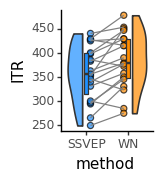

<ggplot: (8786712609130)>

In [8]:
import pandas.api.types as pdtypes


highITR['method'] = highITR['method'].astype(
    pdtypes.CategoricalDtype(categories=['SSVEP', 'WN']))


highITR['ITR'] = highITR['ITR'].astype('float64')
    
x = stage('when', after_scale='x+shift*alt_sign(x)')
shift = 0.1

def alt_sign(x):
    "Alternate +1/-1 if x is even/odd"
    return (-1) ** x

# shift outward
m1 = aes(x=stage('method', after_scale='x+shift*alt_sign(x)'),group='method')
m2 = aes(x=stage('method', after_scale='x-shift*alt_sign(x)'), group='subject')  # shift inward

lsize = 0.65
fill_alpha=0.7

fig =  (ggplot(highITR, aes('method', 'ITR', fill='method'),)
    + theme_classic()
    + theme(figure_size=(3*cm, 4*cm))

    + geom_violin(m1, style='left-right', alpha=fill_alpha,
                  size=lsize, show_legend=False)
    + geom_point(m2, alpha=0.7, size=2, show_legend=False)
    + geom_line(m2,color='gray')
    + geom_boxplot(m1,width=shift, show_legend=False)
    + scale_fill_manual(values=['dodgerblue', 'darkorange'])
    
)
fig.save(filename='../images/fig4b.svg', dpi=300)
fig.save(filename='../images/fig4b.png', dpi=300)
fig

### Fig4(b) Topograghy comparision

In [9]:
pattern = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'pattern.csv'):
        f = pd.read_csv(subFolder+os.sep+'pattern.csv')
        pattern.append(f)

pattern = pd.concat(pattern, ignore_index=True)
chNames = pattern.loc[(pattern.subject == 'yangyuxing')
                      & (pattern.winLEN == 0.1) & (pattern.method == 'WN'), 'channel'].to_numpy().tolist()
pattern.head()

,Unnamed: 0,channel,band,w,winLEN,method,subject
0,0,FP1,0,0.036322,0.02,WN,yangyuxing
1,1,FPZ,0,-0.006055,0.02,WN,yangyuxing
2,2,FP2,0,-0.006935,0.02,WN,yangyuxing
3,3,AF3,0,0.008668,0.02,WN,yangyuxing
4,4,AF4,0,0.000084,0.02,WN,yangyuxing


/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_73735/162715830.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_73735/162715830.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


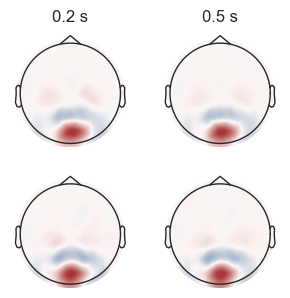

In [32]:
from mne.viz import plot_topomap

winLENs = [0.2,0.5]

list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang', 
        'libowen', 'zhouyuqing', 'miaoyining', 
        'yaofeifan','chenyuzhen']


wnPattern = pattern[(pattern.subject.isin(list))
                        & (pattern.method == 'WN')].groupby(['channel','winLEN'], as_index=False).mean()

ssvepPattern = pattern[(pattern.subject.isin(list))
                        & (pattern.method == 'SSVEP')].groupby(['channel','winLEN'], as_index=False).mean()

vmin = np.min([wnPattern['w'].min(), ssvepPattern['w'].min()])
vmax = np.max([wnPattern['w'].max(), ssvepPattern['w'].max()])

info = mne.create_info(ch_names=ssvepPattern[ssvepPattern.winLEN==0.1].channel.to_numpy().tolist(), sfreq=250, ch_types='eeg')
fname = 'montage.loc'
montage = mne.channels.read_custom_montage(fname)
info.set_montage(montage)

m = sns.color_palette("vlag", as_cmap=True)
fig,axes = plt.subplots(2,2,figsize=(4.5*2*cm,7.8*cm))

for i,(winLEN,axs) in enumerate(zip(winLENs,axes.T)):

    w1 = wnPattern[wnPattern.winLEN == winLEN].w
    w2 = ssvepPattern[ssvepPattern.winLEN == winLEN].w

    plot_topomap(data=w1, pos=info, cmap=m, contours=0,
                    image_interp='cubic', axes=axs[0], show=False,sensors=False,)

    plot_topomap(data=w2, pos=info, cmap=m, contours=0,
                 image_interp='cubic', axes=axs[1], show=False, sensors=False)

    axs[0].set_title('%s s'%winLEN)

plt.show()
fig.savefig('../images/fig4b.svg',dpi=300)

### Fig4 (c) Train size

In [22]:
trainsize = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'trainSize.csv'):
        f = pd.read_csv(subFolder+os.sep+'trainSize.csv')
        trainsize.append(f)

trainsize = pd.concat(trainsize, ignore_index=True)
trainsize = trainsize.groupby(['subject','winLEN','trainsize','method'],as_index=False).mean()
trainsize.head()

,subject,winLEN,trainsize,method,Unnamed: 0,accuracy,ITR,cv
0,alicia,0.1,2,SSVEP,217.5,0.065625,4.531422,3.5
1,alicia,0.1,2,WN,17.5,0.078125,8.249136,3.5
2,alicia,0.1,3,SSVEP,257.5,0.118750,14.347035,3.5
3,alicia,0.1,3,WN,57.5,0.115625,16.245423,3.5
4,alicia,0.1,4,SSVEP,297.5,0.146875,21.303859,3.5


In [23]:
highTrain = []

for subject in list:
        for method in trainsize.method.unique():
                for size in trainsize.trainsize.unique():
                        f = trainsize[(trainsize.subject==subject)&(trainsize.method==method)&(trainsize.trainsize==size)]
                        highTrain.append(f.iloc[f['ITR'].argmax(), :].T)
highTrain = pd.concat(highTrain,ignore_index=False,axis=1).T

ValueError: attempt to get argmax of an empty sequence

In [21]:
diff = []
for subject in highTrain.subject.unique():
    f = highTrain[highTrain.subject==subject]
    f = f.pivot_table(index='trainsize',columns='method',values='ITR')
    f['diff'] = f['WN']-f['SSVEP']
    f['subject'] = subject
    f = f.reset_index()
    diff.append(f)
diff = pd.concat(diff,axis=0,ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


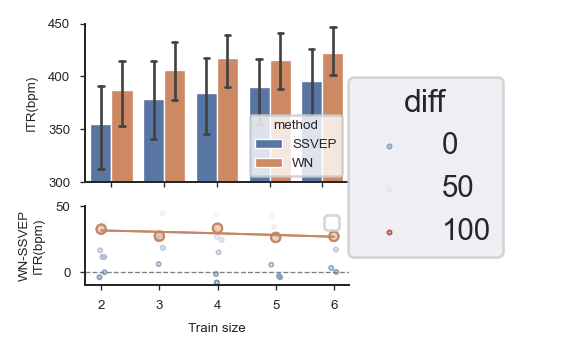

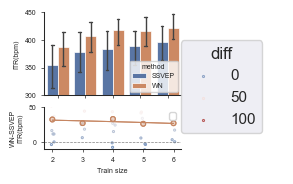

In [22]:

sns.set_theme(style='ticks',font='Arial',rc={"lines.linewidth": 1,'font.size':5,'legend.fontsize':5,'legend.title_fontsize':5,'axes.labelsize':5,'xtick.labelsize':5,'ytick.labelsize':5,})

fig, (ax1, ax2) = plt.subplots(figsize=(4.5*cm, 4.5*cm),
                               nrows=2, ncols=1, height_ratios=[2, 1])

ax1.set_ylim(300, 450)
ax2.set_ylim(-10, 50)
ax2.axhline(y=0, color="gray", linestyle="--",linewidth=0.5)

sns.despine()

for ax in fig.axes:

    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xlabel('Train Size', fontdict=fontdict)
    ax.legend(fontsize=7)


sns.barplot(data=highTrain, x='trainsize', y='ITR', hue='method',
            ax=ax1, linewidth=0.5, errwidth=1, capsize=0.1,)

ax1.set_xlabel([])
ax1.set_xticklabels([])
ax1.set_ylabel('ITR(bpm)')

(
    so.Plot(diff, x='trainsize', y='diff',color='diff')
    .on(ax2)
    .add(so.Dots(pointsize=1.5), so.Jitter(.2),)
    .scale(color='vlag')
    .save('../images/fig4c1.svg', dpi=300)
)

(
    so.Plot(diff, x='trainsize', y='diff',)
    .on(ax2)
    .add(so.Line(linewidth=0.75, color='#C68662'), so.PolyFit(),)
    .add(so.Dots(pointsize=3.5, color='#C68662'), so.Agg(),)
    .label(x='Train size', y='WN-SSVEP\nITR(bpm)')
    .save('../images/fig4c1.svg', dpi=300)
)

# plt.savefig('../images/fig4c1.png',dpi=300)

### Fig 4(d) Montage

In [25]:
montage = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'montage.csv'):
        f = pd.read_csv(subFolder+os.sep+'montage.csv')
        montage.append(f)

montage = pd.concat(montage, ignore_index=True)
montage = montage.groupby(
    ['subject', 'winLEN', 'method', 'monatage'], as_index=False).mean()
montage.head()

,subject,winLEN,method,monatage,Unnamed: 0,accuracy,ITR,cv
0,alicia,0.1,SSVEP,All,377.5,0.21875,44.323857,3.5
1,alicia,0.1,SSVEP,Central occipital,217.5,0.07500,7.260514,3.5
2,alicia,0.1,SSVEP,Occipital,297.5,0.24375,53.712146,3.5
3,alicia,0.1,SSVEP,Parieto-occipital,337.5,0.24375,54.160302,3.5
4,alicia,0.1,SSVEP,classical,257.5,0.18125,32.615698,3.5


In [25]:

highMontage = []

for subject in list:
        for method in montage.method.unique():
                for m in montage.monatage.unique():
                        f = montage[(montage.subject==subject)&(montage.method==method)&(montage.monatage==m)]
                        highMontage.append(f.iloc[f['ITR'].argmax(), :].T)

highMontage = pd.concat(highMontage,ignore_index=False,axis=1).T

In [26]:
diff = []
for subject in highMontage.subject.unique():
    f = highMontage[highMontage.subject == subject]
    f = f.pivot_table(index='monatage', columns='method', values='ITR')
    f['diff'] = f['WN']-f['SSVEP']
    f['subject'] = subject
    f = f.reset_index()
    diff.append(f)
diff = pd.concat(diff, axis=0, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


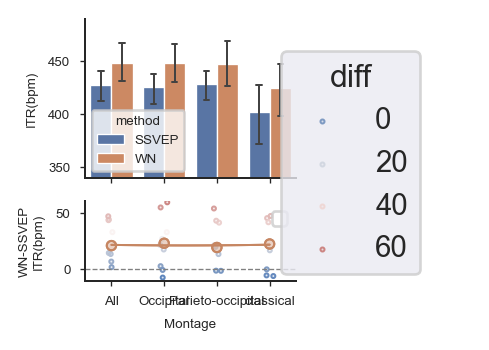

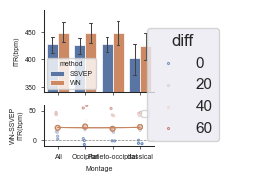

In [27]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
                                               'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1, ax2) = plt.subplots(figsize=(3.6*cm, 4.5*cm),
                               nrows=2, ncols=1, height_ratios=[2, 1])

ax1.set_ylim(340, 490)
ax2.set_ylim(-10, 60)

ax2.axhline(y=0, color="gray", linestyle="--", linewidth=0.5)

sns.despine()

for ax in fig.axes:

    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xlabel('Train Size', fontdict=fontdict)
    ax.legend(fontsize=7)


sns.barplot(data=highMontage[highMontage.monatage != 'Central occipital'], x='monatage', y='ITR', hue='method',ax=ax1, linewidth=0.5, errwidth=0.75, capsize=0.1,)


ax1.set_xlabel([])
ax1.set_xticklabels([])
ax1.set_ylabel('ITR(bpm)')

(
    so.Plot(diff[diff.monatage != 'Central occipital'], x='monatage', y='diff',color='diff')
    .on(ax2)
    .add(so.Dots(pointsize=1.5), so.Jitter(.2),)
    .scale(color='vlag')
    .save('../images/fig4c2.svg', dpi=300)
)

(
    so.Plot(diff[diff.monatage != 'Central occipital'], x='monatage', y='diff',)
    .on(ax2)
    .add(so.Line(linewidth=0.75, color='#C68662'), so.PolyFit(),)
    .add(so.Dots(pointsize=3.5, color='#C68662'), so.Agg(),)
    .label(x='Montage', y='WN-SSVEP\nITR(bpm)')
    .save('../images/fig4c2.svg', dpi=300)
)
# plt.savefig('../images/fig4c2.png',dpi=300)

### Fig 4(e) Bands

In [28]:
bands = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'bands.csv'):
        f = pd.read_csv(subFolder+os.sep+'bands.csv')
        bands.append(f)

bands = pd.concat(bands, ignore_index=True)
bands = bands.groupby(
    ['subject', 'winLEN', 'method', 'band'], as_index=False).mean()
bands.head()

,subject,winLEN,method,band,Unnamed: 0,accuracy,ITR,cv
0,alicia,0.1,SSVEP,1,217.5,0.081250,7.868258,3.5
1,alicia,0.1,SSVEP,2,257.5,0.140625,21.310219,3.5
2,alicia,0.1,SSVEP,3,297.5,0.175000,31.631266,3.5
3,alicia,0.1,SSVEP,4,337.5,0.190625,36.013383,3.5
4,alicia,0.1,SSVEP,5,377.5,0.178125,30.825517,3.5


In [29]:
list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang', 'libowen', 'zhouyuqing','miaoyining']

# list = bands.subject.unique()
highBand = []

for subject in list:
    for method in bands.method.unique():
        for b in bands.band.unique():
            f = bands[(bands.subject==subject)&(bands.method==method)&(bands.band==b)]
            highBand.append(f.iloc[f['ITR'].argmax(), :].T)

highBand = pd.concat(highBand,ignore_index=False,axis=1).T

In [30]:
diff = []
for subject in highBand.subject.unique():
    f = highBand[highBand.subject == subject]
    f = f.pivot_table(index='band', columns='method', values='ITR')
    f['diff'] = f['WN']-f['SSVEP']
    f['subject'] = subject
    f = f.reset_index()
    diff.append(f)
diff = pd.concat(diff, axis=0, ignore_index=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


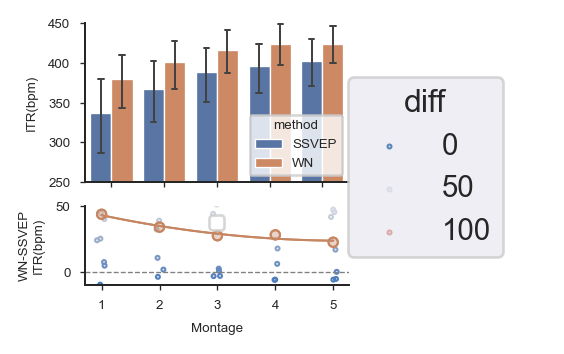

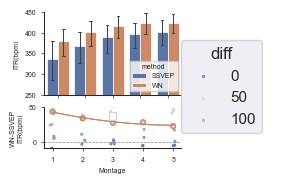

In [31]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
                                               'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1, ax2) = plt.subplots(figsize=(4.5*cm, 4.5*cm),
                               nrows=2, ncols=1, height_ratios=[2, 1])

ax1.set_ylim(250, 450)
ax2.set_ylim(-10, 50)

ax2.axhline(y=0, color="gray", linestyle="--", linewidth=0.5)

sns.despine()

for ax in fig.axes:

    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xlabel('Train Size', fontdict=fontdict)
    ax.legend(fontsize=7)


sns.barplot(data=highBand, x='band', y='ITR', hue='method',
            ax=ax1, linewidth=0.5, errwidth=0.75, capsize=0.1,)


ax1.set_xlabel([])
ax1.set_xticklabels([])
ax1.set_ylabel('ITR(bpm)')

(
    so.Plot(diff, x='band', y='diff',color='diff')
    .on(ax2)
    .add(so.Dots(pointsize=1.5), so.Jitter(.2),)
    .scale(color='vlag')
    .save('../images/fig4c3.svg', dpi=300)
)

(
    so.Plot(diff, x='band', y='diff',)
    .on(ax2)
    .add(so.Line(linewidth=0.75, color='#C68662'), so.PolyFit(),)
    .add(so.Dots(pointsize=3.5, color='#C68662'), so.Agg(),)
    .label(x='Montage', y='WN-SSVEP\nITR(bpm)')
    .save('../images/fig4c3.svg', dpi=300)
)


### Fig4(f) Evokeds

In [9]:
evokeds = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'evoked.csv'):
        f = pd.read_csv(subFolder+os.sep+'evoked.csv')
        evokeds.append(f)

evokeds = pd.concat(evokeds, ignore_index=True)
evokeds.head()

,Unnamed: 0,class,time,evoked,tag,subject,filtered
0,0,1,0.0,0.001968,WN,yangyuxing,no
1,1,2,0.0,-0.136521,WN,yangyuxing,no
2,2,3,0.0,-0.068320,WN,yangyuxing,no
3,3,4,0.0,0.035030,WN,yangyuxing,no
4,4,5,0.0,0.099347,WN,yangyuxing,no


In [12]:
coefs = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'coef.csv'):
        f = pd.read_csv(subFolder+os.sep+'coef.csv')
        coefs.append(f)

coefs = pd.concat(coefs, ignore_index=True)
coefs.head()

,Unnamed: 0,j,i,rho,subject,method,winLEN
0,0,1,1,2.185500,yangyuxing,WN,0.2
1,1,2,1,0.356605,yangyuxing,WN,0.2
2,2,3,1,-0.245055,yangyuxing,WN,0.2
3,3,4,1,-0.961258,yangyuxing,WN,0.2
4,4,5,1,1.036193,yangyuxing,WN,0.2


In [14]:
psds = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'psd.csv'):
        f = pd.read_csv(subFolder+os.sep+'psd.csv')
        psds.append(f)

psds = pd.concat(psds, ignore_index=True)
psds.head()

,Unnamed: 0,class,frequency,evoked,tag,subject
0,0,1,2.0,4.659153e-14,WN,yangyuxing
1,1,2,2.0,4.964478e-14,WN,yangyuxing
2,2,3,2.0,6.708052e-14,WN,yangyuxing
3,3,4,2.0,8.839919e-14,WN,yangyuxing
4,4,5,2.0,7.148115e-14,WN,yangyuxing


/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_62420/2121048025.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


(-0.3, 0.3)

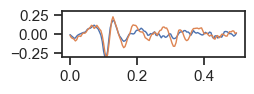

In [15]:
fig,aveax = plt.subplots(figsize=(6*cm, 1.5*cm))
aves = evokeds[(evokeds.filtered=='no')&(evokeds.time < 0.5)].groupby(['time','tag'], as_index=False).mean()
aveax.plot(aves[aves.tag == 'SSVEP'].time,aves[aves.tag == 'SSVEP'].evoked,linewidth=1)
aveax.plot(aves[aves.tag == 'SSVEP'].time, -aves[aves.tag == 'WN'].evoked,linewidth=1)
aveax.set_ylim(-0.3,0.3)

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_62420/3242064956.py:33: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_62420/3242064956.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_62420/3242064956.py:54: UserWarning: 
The palette list has fewer values (1) than needed (40) and will cycle, which may produce an uninterpretable plot.
/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_62420/3242064956.py:56: UserWarning: 
The palette list has fewer values (1) than needed (4

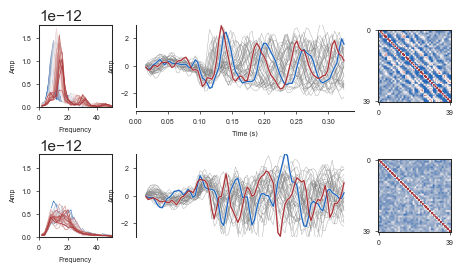

In [16]:
fig = plt.figure(figsize=(13.5*cm, 7*cm))

plt.subplots_adjust(wspace=1, hspace=0.1)
ax10 = plt.subplot2grid((5, 9), (0, 0), colspan=2, rowspan=2)
ax20 = plt.subplot2grid((5, 9), (3, 0), colspan=2, rowspan=2)

ax11 = plt.subplot2grid((5, 9), (0, 2), colspan=5, rowspan=2)
axaxes = plt.subplot2grid((5, 9), (2, 2), colspan=5, rowspan=1)

ax21 = plt.subplot2grid((5, 9), (3, 2), colspan=5, rowspan=2)
ax12 = plt.subplot2grid((5, 9), (0, 7), colspan=2, rowspan=2)
ax22 = plt.subplot2grid((5, 9), (3, 7), colspan=2, rowspan=2)


for spine in ['top', 'right', 'bottom']:
    ax11.spines[spine].set_visible(False)
ax11.set_xticklabels([])
ax11.set_xticks([])

for spine in ['top', 'right', 'left']:
    axaxes.spines[spine].set_visible(False)
axaxes.spines['bottom'].set_position(('data', 1))
axaxes.set_yticklabels([])
axaxes.set_yticks([])
axaxes.set_xlim(0,0.34)

for spine in  ['top', 'right', 'bottom']:
    ax21.spines[spine].set_visible(False)
ax21.spines['bottom'].set_position(('data', 1))
ax21.set_xticklabels([])
ax21.set_xticks([])

aves = psds.groupby(['frequency', 'tag','class'], as_index=False).mean()
sns.lineplot(data=aves[aves.tag == 'SSVEP'], x='frequency',
             y='evoked', hue='class', ax=ax10, legend=False, linewidth=0.5,palette='vlag')
sns.lineplot(data=aves[aves.tag == 'WN'], x='frequency',
             y='evoked', hue='class', ax=ax20, legend=False, linewidth=0.5, palette='vlag')

ax10.set_xlabel('Frequency',fontdict=fontdict)
ax20.set_xlabel('Frequency',fontdict=fontdict)
ax10.set_ylabel('Amp',fontdict=fontdict)
ax20.set_ylabel('Amp',fontdict=fontdict)
ax10.set_ylim(0,1.8*1e-12)
ax20.set_ylim(0,1.8*1e-12)
ax10.set_xlim(0,50)
ax20.set_xlim(0,50)


list = ['zhouyuqing']

aveSSVEP = evokeds[(evokeds.tag == 'SSVEP') & (evokeds.time < 0.34) & (evokeds.subject.isin(list)) & (
    evokeds['class'].isin(np.arange(41, 81, 1)))].groupby(['class', 'time','filtered'], as_index=False).mean()

sns.lineplot(data=aveSSVEP[aveSSVEP.filtered=='no'], x='time', y='evoked', hue='class',
             linewidth=1, palette=['white'], alpha=1, ax=ax11, legend=False)
sns.lineplot(data=aveSSVEP[aveSSVEP.filtered=='no'], x='time', y='evoked', hue='class',
             linewidth=0.3, palette=['gray'], alpha=0.7, ax=ax11, legend=False)


sns.lineplot(data=aveSSVEP[aveSSVEP['class'].isin([78, 79]) & (aveSSVEP.filtered == 'no')], x='time', y='evoked', hue='class',linewidth=1.5, palette=['white'], alpha=1,ax=ax11,legend=False)

sns.lineplot(data=aveSSVEP[aveSSVEP['class'].isin([78, 79]) & (aveSSVEP.filtered == 'no')], x='time', y='evoked', hue='class',linewidth=1, palette='vlag', alpha=1,ax=ax11,legend=False)


aveWN = evokeds[(evokeds.tag == 'WN') & (evokeds.time < 0.34) & (evokeds.subject.isin(list)) & (
    evokeds['class'].isin(np.arange(1, 40, 1)))].groupby(['class', 'time','filtered'], as_index=False).mean()

sns.lineplot(data=aveWN[aveWN.filtered=='no'], x='time', y='evoked', hue='class',
             linewidth=0.3, palette=['gray'], alpha=0.7, ax=ax21,legend=False)

sns.lineplot(data=aveWN[(aveWN['class'].isin([1, 6])) & (aveWN.filtered == 'no')], x='time',
             y='evoked', hue='class', linewidth=1.5, palette=['white'], alpha=1, ax=ax21, legend=False)

sns.lineplot(data=aveWN[(aveWN['class'].isin([1,6])) & (aveWN.filtered == 'no')], x='time', y='evoked', hue='class',linewidth=1, palette='vlag', alpha=1, ax=ax21, legend=False)

ax11.set_ylim(-3,3)
ax21.set_ylim(-3,3)


list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang', 
        'libowen', 'zhouyuqing', 'miaoyining', 
        'yaofeifan','chenyuzhen','shixinge',
        'suxiaohan','quyuxin','zhaoxinyu',
        'jiaqi']

coefWN = pd.pivot_table(data=coefs[(coefs.method=='WN')&(coefs.subject.isin(list))],values='rho',index='i',columns='j').to_numpy()
coefSSVEP = pd.pivot_table(data=coefs[(coefs.method == 'SSVEP') & (coefs.subject.isin(list))], values='rho', index='i', columns='j').to_numpy()

mins = np.max([np.min(coefWN),np.min(coefSSVEP)])
maxs = np.min([np.max(coefWN),np.max(coefSSVEP)])

c = ax12.imshow(coefSSVEP,cmap='vlag',vmin=mins,vmax=maxs-1)
c = ax22.imshow(coefWN, cmap='vlag', vmin=mins, vmax=maxs-1)

ax12.xaxis.set_major_locator(ticker.IndexLocator(base=39, offset=0.5))
ax12.yaxis.set_major_locator(ticker.IndexLocator(base=39, offset=0.5))
ax22.xaxis.set_major_locator(ticker.IndexLocator(base=39, offset=0.5))
ax22.yaxis.set_major_locator(ticker.IndexLocator(base=39, offset=0.5))

for ax in fig.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

axaxes.set_xlabel('Time (s)',fontdict=fontdict)
ax11.set_ylabel('Amp',fontdict=fontdict)
ax21.set_ylabel('Amp',fontdict=fontdict)

fig.savefig('../images/fig4f.png',dpi=300)

## Fig (g) SNR

In [ ]:
snrs = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'snr.csv'):
        f = pd.read_csv(subFolder+os.sep+'snr.csv')
        snrs.append(f)

snrs = pd.concat(snrs, ignore_index=True)
snrs.head()

In [ ]:
list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang', 'libowen', 'zhouyuqing','yaofeifan']

sns.set_theme(style='ticks',font='Arial',rc={"lines.linewidth": 1,'font.size':5,'legend.fontsize':5,'legend.title_fontsize':5,'axes.labelsize':5,'xtick.labelsize':5,'ytick.labelsize':5,})

fig,ax = plt.subplots(figsize=(1.5*cm,5.5*cm))
sns.kdeplot(data=snrs[snrs.subject.isin(list)],y='snr',hue='method')

ax.set_ylabel('SNR(dB)')
for ax in fig.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
    plt.setp(ax.spines.values(), linewidth=0.75)

fig.savefig('../images/fig4g.svg', dpi=300, bbox_inches='tight')

## Fig 4(h) Error plot

In [29]:
error = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'error.csv'):
        f = pd.read_csv(subFolder+os.sep+'error.csv')
        error.append(f)
    
error = pd.concat(error, ignore_index=True)
error.head()

,Unnamed: 0,class,cv,error,winLEN,type,subject
0,0,1,0,0,0.1,WN,yangyuxing
1,1,2,0,1,0.1,WN,yangyuxing
2,2,3,0,1,0.1,WN,yangyuxing
3,3,4,0,0,0.1,WN,yangyuxing
4,4,5,0,0,0.1,WN,yangyuxing


In [30]:
error.subject.unique()

array(['yangyuxing', 'xuwenjia', 'zhouyuqing', 'yuciheng', 'wangchaoying',
       'libowen', 'lijiayang', 'zhaoxinyu', 'gongcongcong', 'ehab',
       'sunjinnan', 'rafi', 'jingyi', 'fanzixiao', 'alicia', 'miaoyining',
       'zhengjiahan', 'yaofeifan'], dtype=object)

In [35]:
list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang',
        'libowen', 'zhouyuqing', 'miaoyining',
        'yaofeifan', 'sunjinnan']

E = []

error = error.groupby(by=['winLEN','class','type','subject'],as_index=False).sum()

for winLEN in error.winLEN.unique():
    for subject in list:
        for type in error.type.unique():
                subError = error[(error.subject==subject)&(error.winLEN==winLEN)&(error.type==type)]
                subError.error = subError.error/subError.error.sum()
                E.append(subError)

error = pd.concat(E,ignore_index=True,axis=0) 
error.head()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_59770/785864922.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,winLEN,class,type,subject,Unnamed: 0,cv,error
0,0.1,1,WN,yangyuxing,2240,28,0.000000
1,0.1,2,WN,yangyuxing,2248,28,0.085714
2,0.1,3,WN,yangyuxing,2256,28,0.028571
3,0.1,4,WN,yangyuxing,2264,28,0.000000
4,0.1,5,WN,yangyuxing,2272,28,0.000000


<AxesSubplot: xlabel='class', ylabel='error'>

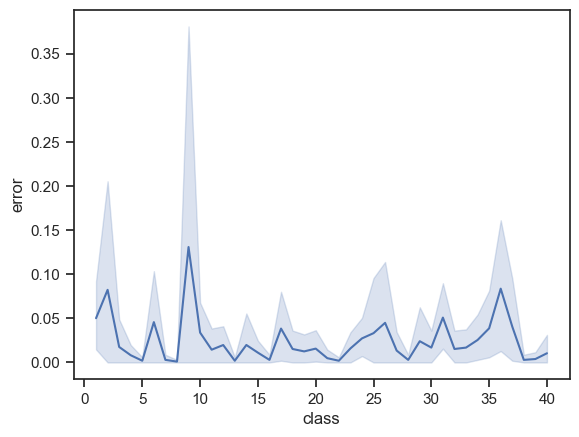

In [38]:
sns.lineplot(data=error[(error.type=='WN')&(error.winLEN==0.2)],x='class',y='error')

<AxesSubplot: xlabel='class', ylabel='type'>

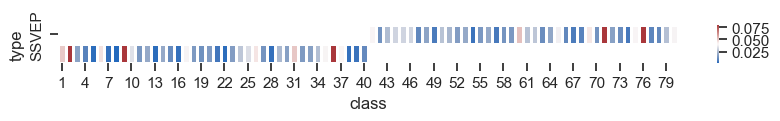

In [40]:
allError = error[(error.winLEN==0.2)].pivot_table(index='type',columns='class',values='error')

fig,(ax1) = plt.subplots(1,1,figsize=(10,0.5))
sns.heatmap(allError,cmap='vlag',ax=ax1,linewidths=1,vmax=0.08)

## Fig 4(i) Layout

In [69]:
layout = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'focus.csv'):
        f = pd.read_csv(subFolder+os.sep+'focus.csv')
        layout.append(f)
    
layout = pd.concat(layout, ignore_index=True)
layout

,Unnamed: 0,cord,class,rho,subject,tag,winLEN,cv,accuracy
0,0,center,1,0.000764,yangyuxing,WN,0.2,0,0.950
1,1,up,1,NaN,yangyuxing,WN,0.2,0,0.950
2,2,left,1,NaN,yangyuxing,WN,0.2,0,0.950
3,3,right,1,0.469771,yangyuxing,WN,0.2,0,0.950
4,4,down,1,0.801894,yangyuxing,WN,0.2,0,0.950
...,...,...,...,...,...,...,...,...,...
129595,5755,down,80,0.302364,yaofeifan,SSVEP,0.2,7,0.925
129596,5756,upRight,80,0.541474,yaofeifan,SSVEP,0.2,7,0.925
129597,5757,upLeft,80,0.396344,yaofeifan,SSVEP,0.2,7,0.925
129598,5758,downRight,80,0.678500,yaofeifan,SSVEP,0.2,7,0.925


In [70]:

list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang',
        'libowen', 'zhouyuqing', 'miaoyining',
        'yaofeifan', 'chenyuzhen', 'shixinge',
        'suxiaohan', 'quyuxin', 'zhaoxinyu',
        'jiaqi']

layout = layout[layout.subject.isin(list)].groupby(by=['tag','subject','winLEN','cord'],as_index=False).mean()
layout.head()

,tag,subject,winLEN,cord,Unnamed: 0,class,rho,cv,accuracy
0,SSVEP,chenyuzhen,0.2,center,4315.5,60.5,0.034608,3.5,0.81875
1,SSVEP,chenyuzhen,0.2,down,4319.5,60.5,0.469690,3.5,0.81875
2,SSVEP,chenyuzhen,0.2,downLeft,4323.5,60.5,0.470933,3.5,0.81875
3,SSVEP,chenyuzhen,0.2,downRight,4322.5,60.5,0.470956,3.5,0.81875
4,SSVEP,chenyuzhen,0.2,left,4317.5,60.5,0.479385,3.5,0.81875


In [63]:
list = ['yangyuxing', 'xuwenjia', 'jingyi',
        'fanzixiao', 'wangchaoying', 'lijiayang', 
        'libowen', 'zhouyuqing', 'miaoyining', 
        'yaofeifan','chenyuzhen','shixinge',
        'suxiaohan','quyuxin','zhaoxinyu',
        'jiaqi']

layout = layout[layout.subject.isin(list)].groupby(by=['tag','winLEN','cord'],as_index=False).mean()
layout

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_24786/3467663063.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,tag,winLEN,cord,Unnamed: 0,class,rho,cv,accuracy
0,SSVEP,0.2,center,4315.5,60.5,0.024230,3.5,0.881641
1,SSVEP,0.2,down,4319.5,60.5,0.442659,3.5,0.881641
2,SSVEP,0.2,downLeft,4323.5,60.5,0.430111,3.5,0.881641
3,SSVEP,0.2,downRight,4322.5,60.5,0.440455,3.5,0.881641
4,SSVEP,0.2,left,4317.5,60.5,0.435797,3.5,0.881641
5,SSVEP,0.2,right,4318.5,60.5,0.450685,3.5,0.881641
6,SSVEP,0.2,up,4316.5,60.5,0.440205,3.5,0.881641
7,SSVEP,0.2,upLeft,4321.5,60.5,0.440205,3.5,0.881641
8,SSVEP,0.2,upRight,4320.5,60.5,0.454732,3.5,0.881641
9,WN,0.2,center,1435.5,20.5,0.017196,3.5,0.934375


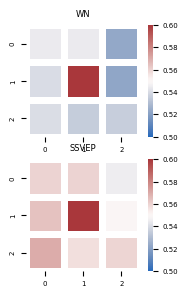

In [67]:
nz = layout.rho.to_numpy()
vmin = np.min(nz[np.nonzero(nz)])
vmax = np.max(nz[np.nonzero(nz)])

m = []
for tag in ['WN','SSVEP']:
    for cord in ['upLeft','up','upRight','left','center','right','downLeft','down','downRight']:
        m.append(layout[layout.tag==tag].loc[layout.cord==cord]['rho'].to_numpy()[0])

layoutWN = np.reshape(m[:9],(3,3))
layoutSSVEP = np.reshape(m[9:], (3, 3))

f,(ax1,ax2) = plt.subplots(2,1,figsize=(1.85,3.2))
sns.heatmap(1-layoutWN, linewidths=5, ax=ax1, cmap='vlag', vmin=0.5, vmax=0.6)
sns.heatmap(1-layoutSSVEP, linewidths=5, ax=ax2, cmap='vlag',vmin=0.5,vmax=0.6)

ax1.set_title('WN')
ax2.set_title('SSVEP')

f.savefig('../images/fig4i.png',dpi=300)

# Fig 5

In [34]:
capacity = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'info.csv'):
        f = pd.read_csv(subFolder+os.sep+'info.csv')
        capacity.append(f)

capacity = pd.concat(capacity, ignore_index=True).drop_duplicates()
capacity = capacity[capacity.f>=1]
capacity.head()

,Unnamed: 0,f,lbSNR,lbrate,ubSNR,ubrate,SS,NN,sPower,nPower,Hf,X,STI,subject,ubINFO,lbINFO
1,1,1.0,0.021516,4.713826,3.592164,3.728833,1.689765,78.534016,6.924827e-13,1.927759e-13,11128.676004,8.852586e-13,0.311847,yangyuxing,155.136107,(24.50618423384747+0j)
2,2,2.0,0.018425,4.740165,3.658843,5.948804,1.856543,100.764188,7.632704e-13,2.086098e-13,15614.705382,9.718802e-13,0.397217,yangyuxing,155.136107,(24.50618423384747+0j)
3,3,3.0,0.028503,4.780712,3.780281,8.205899,2.255682,79.137561,9.139129e-13,2.417579e-13,43632.747063,1.155671e-12,0.299989,yangyuxing,155.136107,(24.50618423384747+0j)
4,4,4.0,0.040098,4.837431,3.952837,10.514154,3.101567,77.350184,1.236394e-12,3.127866e-13,20752.283527,1.549181e-12,0.308399,yangyuxing,155.136107,(24.50618423384747+0j)
5,5,5.0,0.076027,4.943145,4.032661,12.845476,6.153201,80.934510,2.206189e-12,5.470802e-13,48850.878505,2.753269e-12,0.327070,yangyuxing,155.136107,(24.50618423384747+0j)


In [25]:
# red
red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

## Fig 5(a) Response and STI FFT

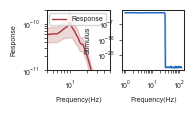

In [26]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(4.5*cm, 2*cm))

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })


sns.lineplot(data=capacity, x='f', y='X', ax=ax,label='Response',color=red)
sns.lineplot(data=capacity, x='f', y='STI', ax=ax1,color=blue)

ax.set_xlim(4, 50)
ax.set_ylim(1e-11, 2e-10)

ax.set_ylabel('Response')
ax1.set_ylabel('Stimulus')

for ax in fig.axes:
    
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

    ax.set_xlabel('Frequency(Hz)')
    ax.set_yscale('log')
    ax.set_xscale('log')

fig.savefig('../images/fig5a.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5a.svg',dpi=300,bbox_inches='tight')

## Fig5 (b) SNR

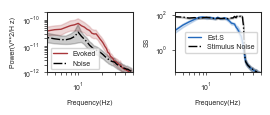

In [27]:

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7*cm,2*cm))

plt.subplots_adjust(wspace=0.5)

sns.lineplot(data=capacity,
             x='f', y='sPower', ax=ax1, label='Evoked',color=red)

sns.lineplot(data=capacity,
             x='f', y='nPower', ax=ax1, label='Noise', color='black', linestyle='dashdot')

sns.lineplot(data=capacity,
             x='f', y='SS', ax=ax2, label='Est.S', color=blue)

sns.lineplot(data=capacity,
             x='f', y='NN', ax=ax2, label='Stimulus Noise', color='black', linestyle='dashdot')


ax1.set_ylim(1e-12, 2e-10)
ax2.set_ylim(5e-2, 1.5e2)

for ax in fig.axes:

    ax.set_xlabel('Frequency(Hz)')
    ax1.set_ylabel(r'Power(V**2/H z)')

    ax.set_xlim(4, 50)
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

    ax.set_yscale('log')
    ax.set_xscale('log')

fig.savefig('../images/fig5b.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5b.svg',dpi=300,bbox_inches='tight')

## Fig 5(c) SNR rate

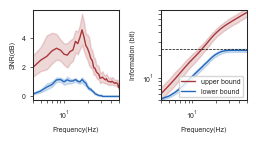

In [28]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7*cm,3*cm))

plt.subplots_adjust(wspace=0.5)

sns.lineplot(data=capacity, x='f', y='ubSNR', ax=ax1,color=red)

sns.lineplot(data=capacity, x='f', y='lbSNR', ax=ax1, color=blue)

sns.lineplot(data=capacity, x='f', y='ubrate',
             ax=ax2, label='upper bound', color=red)

sns.lineplot(data=capacity, x='f', y='lbrate', ax=ax2,label='lower bound',color=blue)


for ax in fig.axes:

    ax.set_xlim(4, 50)
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xscale('log')
    ax.set_xlabel('Frequency(Hz)')

ax2.axhline(y=24,color='black',linewidth=0.5,linestyle='dashed')
ax1.set_ylabel('SNR(dB)')
ax2.set_ylabel('Information (bit)')

ax2.set_ylim(5, 80)
ax2.set_yscale('log')

fig.savefig('../images/fig5c.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5c.svg',dpi=300,bbox_inches='tight')

## Fig 5(d) Evoked and single trial

In [22]:
import pickle
srate = 250
expName = 'sweep'

tau = np.arange(-0.5, 0.1+1/srate, 1/srate)
ts = np.arange(0, 1, 1/srate)

dir = '../datasets/%s.pickle' % expName

with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-3]
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2','PO3']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']

'yangyuxing'

In [165]:
from modeling import EEG2Code
model = EEG2Code(srate=srate,winLEN=1,tmin=-0.5,tmax=0.1,S=(S,np.unique(y)),estimator=0.98,padding=True,n_band=1,component=1)
model.fit(X,y)
sEst = model.predict(X)
xX = model.enhancer.transform(X)

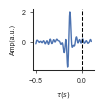

In [54]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,ax = plt.subplots(figsize = (2*cm,2*cm))
ax.plot(tau,model.trf.T)
ax.axvline(0, linestyle='dashed', color='black', linewidth=0.75)
ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
plt.setp(ax.spines.values(), linewidth=0.75)

ax.set_xlabel(r'$\tau(s)$')
ax.set_ylabel('Amp(a.u.)')

sns.despine()
fig.savefig('../images/fig5d1.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5d1.svg',dpi=300,bbox_inches='tight')

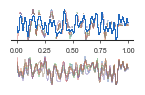

In [175]:
i=4
s = model.STI[np.unique(y)==i]
s = np.repeat(s,repeats=6,axis=0)
es = sEst[y==i]
noise = s-es

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) =plt.subplots(2,1,figsize=(4*cm,2.5*cm))

plt.subplots_adjust(hspace=0.5)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))

ax1.step(ts,es.T,alpha=0.6,linewidth=0.5)
ax1.step(ts,s.T,color='white',linestyle='solid',linewidth=1.2)
ax1.step(ts,s.T,color=blue,linestyle='solid',linewidth=0.5)

ax2.step(ts,noise.T,alpha=0.6,linewidth=0.5)

for ax in (ax1,ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_yticklabels([])
    ax.set_yticks([])

ax1.set_ylim(0,1)
ax2.set_ylim(-0.5, 0.5)
ax1.set_xlabel('Time(s)')

ax2.set_xticklabels([])
ax2.set_xticks([])

fig.savefig('../images/fig5d2.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5d2.svg',dpi=300,bbox_inches='tight')


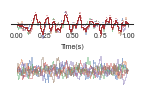

In [176]:
i = 4
s = model.enhanced[np.unique(y)==i][0]
s = np.repeat(s, repeats=6, axis=0)
x = np.squeeze(xX[y==i])
noise = x-s

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4*cm, 2.5*cm))

plt.subplots_adjust(hspace=0.5)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))

ax1.step(ts, x.T, alpha=0.6, linewidth=0.5)
ax1.step(ts, s.T, color='white', linestyle='solid', linewidth=1.2)
ax1.step(ts, s.T, color=red, linestyle='solid', linewidth=0.5)

ax2.step(ts, noise.T, alpha=0.6, linewidth=0.5)

for ax in (ax1, ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_yticklabels([])
    ax.set_yticks([])

ax1.set_xlabel('Time(s)')

ax2.set_xticklabels([])
ax2.set_xticks([])

fig.savefig('../images/fig5d3.png', dpi=300, bbox_inches='tight')
fig.savefig('../images/fig5d3.svg', dpi=300, bbox_inches='tight')

## Fig 5(e) Hf

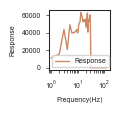

In [37]:
fig, ax = plt.subplots(figsize=(2*cm, 2*cm))

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })


sns.lineplot(data=capacity[capacity.subject=='yangyuxing'], x='f', y='Hf', ax=ax,label='Response',color=orange)

# ax.set_xlim(4, 50)

ax.set_ylabel('Response')
ax1.set_ylabel('Stimulus')

for ax in fig.axes:
    
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

    ax.set_xlabel('Frequency(Hz)')
    # ax.set_yscale('log')
    # ax.set_xscale('log')

fig.savefig('../images/fig5e.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/fig5e.svg',dpi=300,bbox_inches='tight')

# Disccusion

## (1) SOTA

In [3]:
sota = pd.read_csv('SOTA.csv')
sota['place'] = 'Type'
sota.head()

,Name,Year,Method,calibration,Field,Type,ITR,Tags,Authors,Ref,place
0,JFPM SSVEP,2018,noninvasive,0.5,sensory tagging,visual,5.40,visual gaze direction,Nakanishi et al,https://ieeexplore.ieee.org/abstract/document/...,Type
1,brain-to-text,2021,invasive,1-1.5,intention,motor,4.80,handwriting movements attempts,Krishna V. Shenoy et al,https://www.nature.com/articles/s41586-021-035...,Type
2,limb movements,2020,invasive,3-5,intention,motor,4.52,limb movements,Krishna V. Shenoy et al,https://www.sciencedirect.com/science/article/...,Type
3,speech-to-text,2023,invasive,1.5,intention,speech,14.00,articulatory movement,Krishna V. Shenoy et al,https://www.biorxiv.org/content/10.1101/2023.0...,Type
4,Speech synthesis,2019,invasive,1.5,intention,speech,4.00,articulatory movement,David A. Moses et al,https://www.nejm.org/doi/full/10.1056/nejmoa20...,Type


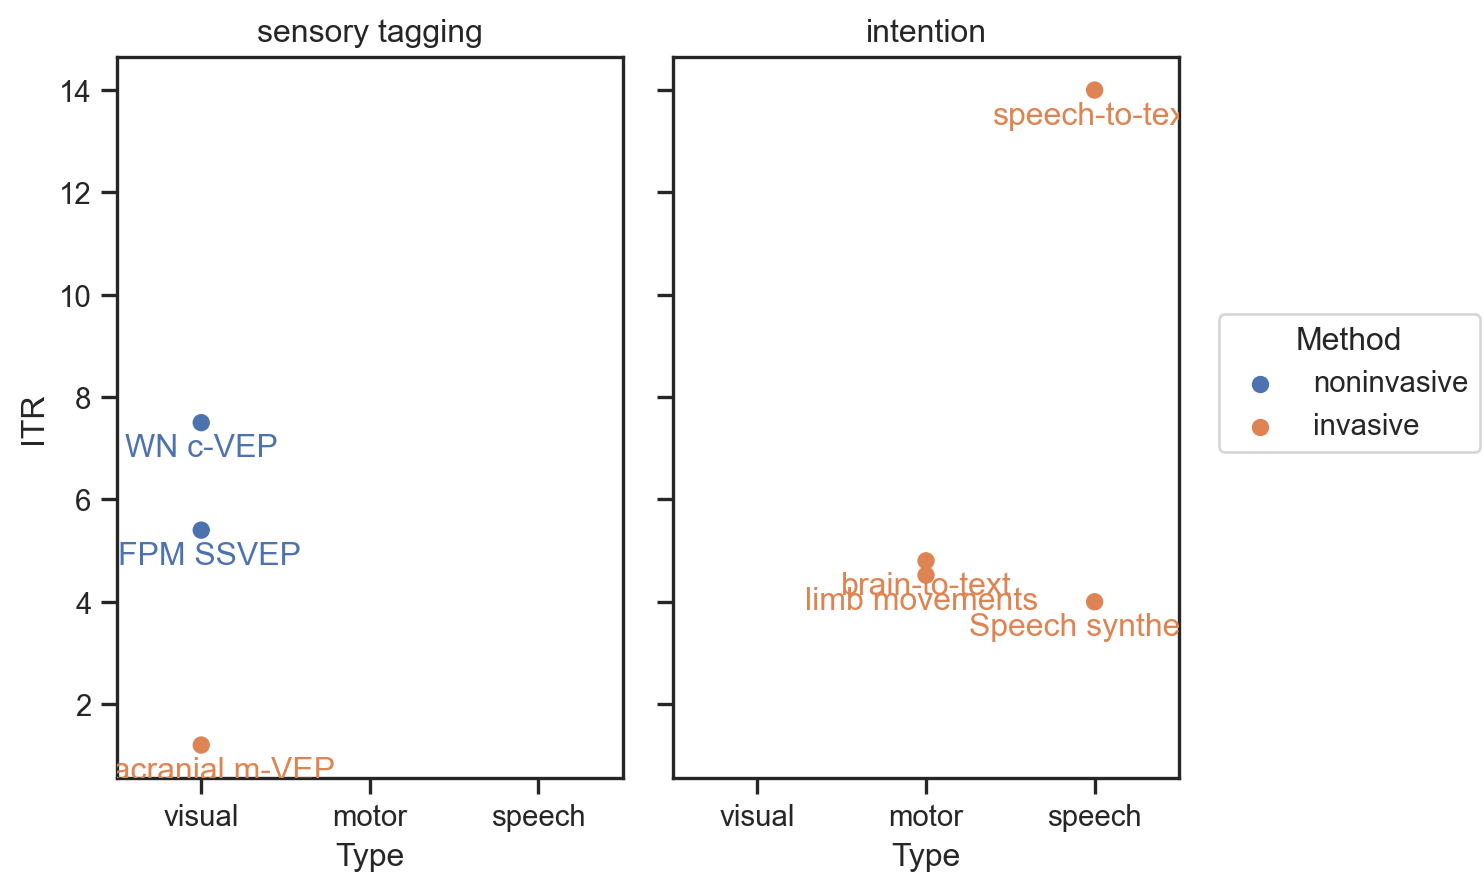

In [13]:
from seaborn import axes_style
import seaborn.objects as so

(
    so.Plot(sota, x="Type", y="ITR", color='Method',
            text="Name").facet(col='Field')
    .theme({**axes_style("ticks"), "grid.linestyle": ":"})
    .add(
        so.Dot(),
    )
    .add(
        so.Text(valign="top")
    )
    .save('../images/sota.svg', dpi=300)
)


In [ ]:
sns.set_theme(style='ticks',font='Arial',rc={"lines.linewidth": 1,'font.size':5,'legend.fontsize':5,'legend.title_fontsize':5,'axes.labelsize':5,'xtick.labelsize':5,'ytick.labelsize':5,})

fig,ax = plt.subplots(figsize=(5*cm,5*cm))
sns.scatterplot(data=sota, x='Year', y='ITR', hue='Method',style='Method',s=50)
for row in sota.iterrows():
    ax.text(x=row[1]['Year'], y=row[1]['ITR']-0.5, s='%s \n %s'%(row[1]['Tags'],row[1]['Authors']),fontdict=fontdict)

ax.tick_params(labelsize=5, width=0.5, length=2, which='major')
plt.setp(ax.spines.values(), linewidth=0.75)

ax.legend(fontsize=5)
fig.savefig('../images/disscusion1.png',dpi=400,bbox_inches='tight')

## (2) TRF with diode

In [ ]:
trfs = []
add = '../results/compare'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'trf.csv'):
        f = pd.read_csv(subFolder+os.sep+'trf.csv')
        trfs.append(f)
    
trfs = pd.concat(trfs, ignore_index=True)
trfs.head()

In [ ]:
list = ['zhouyuqing']

sns.set_theme(style='ticks')
f,ax = plt.subplots(figsize=(5,2))
sns.lineplot(data=trfs[(trfs.subject.isin(list))&(trfs.tau<0.2)],x='tau',y='trf',linewidth=1,palette='crest',legend=False)

In [ ]:

utils.ITR()